# Here are some post processing codes for the cases with Navier-Stokes solver

- [2-Poiseuille-flow-Newtonian.c](../testCases/2-Poiseuille-flow-Newtonian.c)
- [2-Poiseuille-flow-Bingham.c](../testCases/2-Poiseuille-flow-Bingham.c)
- [2-2D_rot_cylinder.c](../testCases/2-2D_rot_cylinder.c)
- [2-2D_rot_cylinder_ink.c](../testCases/2-2D_rot_cylinder_ink.c)
- [2-LidDrivenCavity-Newtonian.c](../testCases/2-LidDrivenCavity-Newtonian.c)

## Post processing code for 2-Poiseuille-flow-Newtonian.c

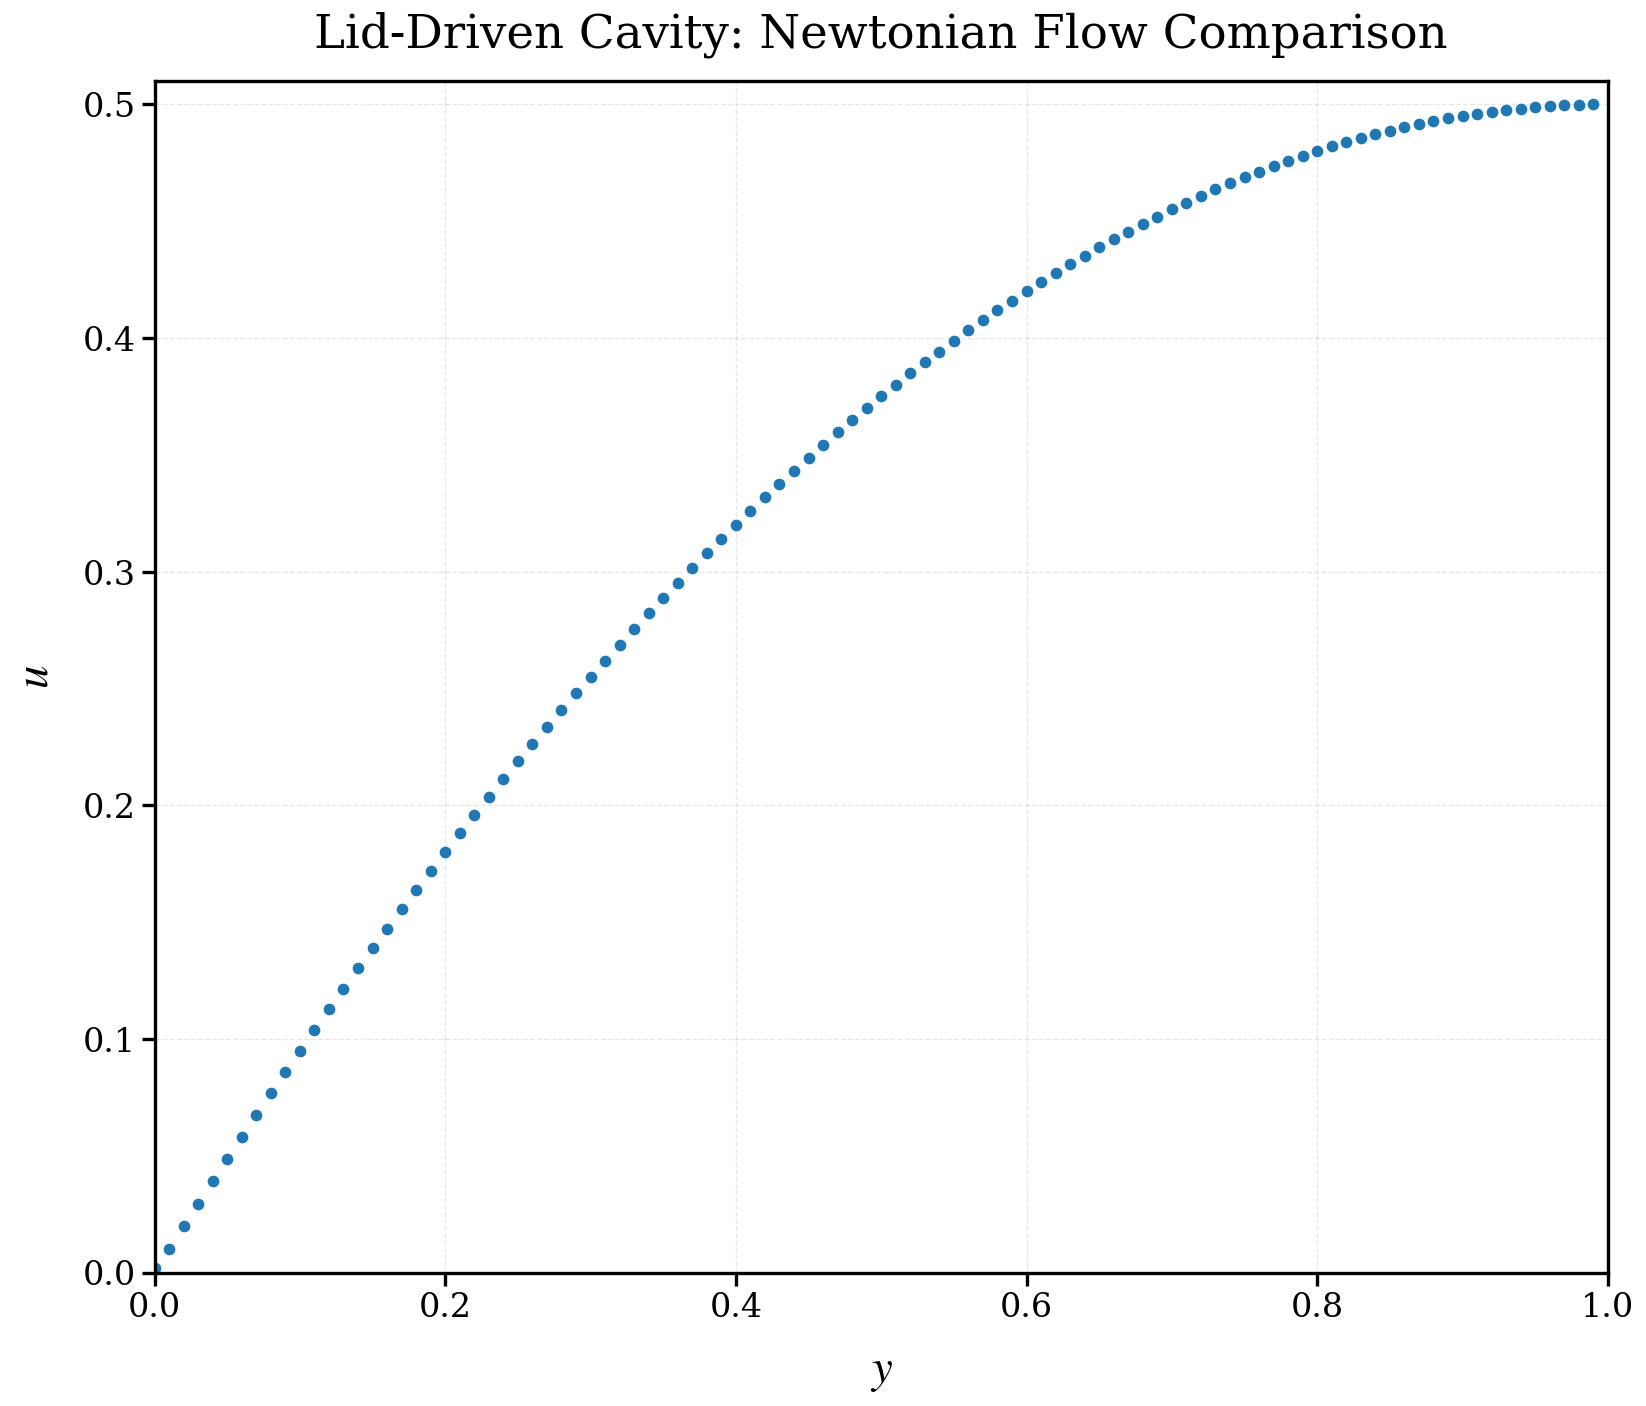

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import matplotlib.colors as mcolors
from scipy.io import loadmat

# Set global font parameters for publication quality
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 16,
    'mathtext.fontset': 'stix',
    'axes.labelsize': 24,
    'axes.titlesize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 18,
})

# Define paths for Basilisk simulation data files
# - Each file corresponds to a different yield stress value
filename = "../testCases/2-Poiseuille-flow-Newtonian/results"

# Collect Basilisk data by running an external data extraction tool
# - The tool extracts velocity profiles along the vertical centerline
result = subprocess.run(['./getData-Line', filename],
                        capture_output=True, text=True)
y_values, u_values = [], []
# Parse the output line by line
for line in result.stderr.strip().split('\n'):
    parts = line.strip().split()
    if len(parts) >= 2:
        y, u = float(parts[0]), float(parts[1])
        # Adjust y-coordinate (shift by 0.5 to match reference data)
        y_values.append(y+0.5)
        u_values.append(u)

y_values = np.array(y_values, dtype=float)
u_values = np.array(u_values, dtype=float)

# Create a high-quality figure for publication
fig, ax = plt.subplots(figsize=(14, 12), dpi=120)
# Configure plot aesthetics for better readability
ax.grid(True, linestyle='--', alpha=0.3, which='major')
ax.set_axisbelow(True)  # Place grid behind data

ax.plot(y_values, u_values, 'o', color='#1f77b4')

# Set axis labels and title with improved formatting
ax.set_xlabel(r'$y$', fontsize=28, labelpad=15)
ax.set_ylabel(r'$u$', fontsize=28, labelpad=15)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 0.51])
ax.set_title('Lid-Driven Cavity: Newtonian Flow Comparison', fontsize=28, pad=20)

# Make tick marks thicker and longer for better visibility
ax.tick_params(width=2, length=8, which='major')
ax.tick_params(width=1.5, length=5, which='minor')

# Make axis spines thicker for better visibility
for spine in ax.spines.values():
    spine.set_linewidth(2)

# Ensure proper layout and save the figure
plt.tight_layout()
fig.set_facecolor('white')
plt.savefig('img/2-LidDrivenCavity-Newtonian.png', bbox_inches='tight')
plt.show()

## Post processing code for 2-Poiseuille-flow-Bingham.c

## Post processing code for 2-2D_rot_cylinder.c


In [12]:
import numpy as np
import os
import subprocess as sp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.ticker import StrMethodFormatter
import multiprocessing as mp
from functools import partial
import argparse  # Add at top with other imports
import sys

import matplotlib.colors as mcolors
custom_colors = ["white", "#DA8A67", "#A0522D", "#400000"]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_hot", custom_colors)

matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

def gettingfield(filename, zmin, zmax, rmin, rmax, nr):
    exe = ["./getData-generic", filename, str(zmin), str(rmin), str(zmax), str(rmax), str(nr)]
    p = sp.Popen(exe, stdout=sp.PIPE, stderr=sp.PIPE)
    stdout, stderr = p.communicate()
    temp1 = stderr.decode("utf-8")
    temp2 = temp1.split("\n")
    # print(temp2) #debugging
    Rtemp, Ztemp, Ttemp, cstemp  = [],[],[],[]

    for n1 in range(len(temp2)):
        temp3 = temp2[n1].split(" ")
        if temp3 == ['']:
            pass
        else:
            Ztemp.append(float(temp3[0]))
            Rtemp.append(float(temp3[1]))
            Ttemp.append(float(temp3[3]))
            cstemp.append(float(temp3[2]))

    R = np.asarray(Rtemp)
    Z = np.asarray(Ztemp)
    T = np.asarray(Ttemp)
    cs = np.asarray(cstemp)
    nz = int(len(Z)/nr)

    # print("nr is %d %d" % (nr, len(R))) # debugging
    print("nz is %d" % nz)

    R.resize((nz, nr))
    Z.resize((nz, nr))
    T.resize((nz, nr))
    cs.resize((nz, nr))

    # rotate by 270 degrees
    R = np.rot90(R, k=1)
    Z = np.rot90(Z, k=1)
    T = np.rot90(T, k=1)
    cs = np.rot90(cs, k=1)
    # flip the array
    R = np.flip(R, axis=0)
    Z = np.flip(Z, axis=0)
    T = np.flip(T, axis=0)
    cs = np.flip(cs, axis=0)

    return R, Z, T, cs, nz
# ----------------------------------------------------------------------------------------------------------------------

def process_timestep(caseToProcess, folder, GridsPerR, rmin, rmax, zmin, zmax, lw):
    place = f"{caseToProcess}"
    name = f"{folder}/2-2D_rot_cylinder.png"

    if not os.path.exists(folder):
        os.makedirs(folder)

    if not os.path.exists(place):
        print(f"{place} File not found!")
        return
    
    nr = int(GridsPerR * rmax)
    R, Z, T, cs, nz = gettingfield(place, zmin, zmax, rmin, rmax, nr)
    zminp, zmaxp, rminp, rmaxp = Z.min(), Z.max(), R.min(), R.max()

    # Plotting
    AxesLabel, TickLabel = 50, 20
    fig, ax = plt.subplots()
    fig.set_size_inches(19.20, 10.80)


    cntrl1 = ax.imshow(T, cmap="viridis", interpolation='Bilinear', origin='lower', extent=[rminp, rmaxp, zminp, zmaxp], vmax=1.0, vmin=0.0)

    # Draw two concentric circles centered at (0,0)
    # Based on the testCases/1-conduction-2D-annulus, we need inner and outer circles
    
    # Get inner and outer radii from the test case
    # Typically these would be defined as INNER_RADIUS and OUTER_RADIUS
    inner_radius = 1.0  # Default value, should match INNER_RADIUS in the test case
    outer_radius = 1.5  # Default value, should match OUTER_RADIUS in the test case
    # Clip the temperature field to the outer circle region so that data outside is not displayed
    outer_circle = plt.Circle((0, 0), outer_radius, transform=ax.transData)
    cntrl1.set_clip_path(outer_circle)
    # Create a white circle for the inner region (this is already working)
    inner_circle = plt.Circle((0, 0), inner_radius, fill=True, color='white', linestyle='-', linewidth=lw)
    ax.add_patch(inner_circle)

    ax.set_aspect('equal')
    ax.set_xlim(rmin, rmax)
    ax.set_ylim(zmin, zmax)

    l, b, w, h = ax.get_position().bounds
    # Left colorbar
    cb1 = fig.add_axes([l-0.04, b, 0.03, h])
    c1 = plt.colorbar(cntrl1, cax=cb1, orientation='vertical')
    c1.set_label(r'$\|u_i\|$', fontsize=TickLabel, labelpad=5)
    c1.ax.tick_params(labelsize=TickLabel)
    c1.ax.yaxis.set_ticks_position('left')
    c1.ax.yaxis.set_label_position('left')
    c1.ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))
    ax.axis('off')
    # Set figure background to white for saving
    fig.patch.set_facecolor('white')
    plt.savefig(name, bbox_inches="tight", facecolor='white')
    plt.show()

nz is 768


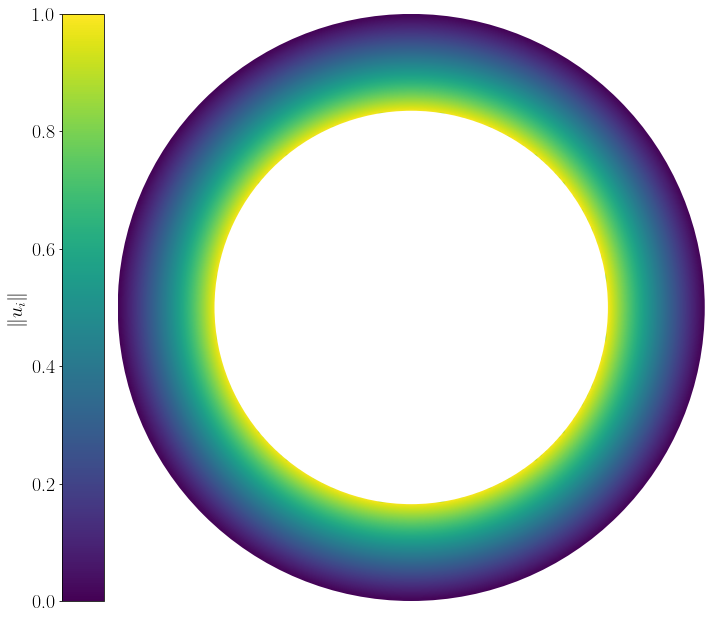

In [13]:
process_timestep(caseToProcess="../testCases/2-2D_rot_cylinder/restart",
                             folder="img",
                             GridsPerR=512, rmin=-1.5, rmax=1.5, 
                             zmin=-1.5, zmax=1.5, lw=2)

## Post processing code for 2-2D_rot_cylinder-ink.c

In [14]:
import numpy as np
import os
import subprocess as sp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.ticker import StrMethodFormatter
import multiprocessing as mp
from functools import partial
import argparse  # Add at top with other imports
import sys

import matplotlib.colors as mcolors
custom_colors = ["white", "#DA8A67", "#A0522D", "#400000"]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_hot", custom_colors)

matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

def gettingfield(filename, zmin, zmax, rmin, rmax, nr):
    exe = ["./getData-2D_rot_cylinder_ink", filename, str(zmin), str(rmin), str(zmax), str(rmax), str(nr)]
    p = sp.Popen(exe, stdout=sp.PIPE, stderr=sp.PIPE)
    stdout, stderr = p.communicate()
    temp1 = stderr.decode("utf-8")
    temp2 = temp1.split("\n")
    # print(temp2) #debugging
    Rtemp, Ztemp, Ttemp, cstemp  = [],[],[],[]

    for n1 in range(len(temp2)):
        temp3 = temp2[n1].split(" ")
        if temp3 == ['']:
            pass
        else:
            Ztemp.append(float(temp3[0]))
            Rtemp.append(float(temp3[1]))
            Ttemp.append(float(temp3[2]))
            cstemp.append(float(temp3[3]))

    R = np.asarray(Rtemp)
    Z = np.asarray(Ztemp)
    T = np.asarray(Ttemp)
    cs = np.asarray(cstemp)
    nz = int(len(Z)/nr)

    # print("nr is %d %d" % (nr, len(R))) # debugging
    print("nz is %d" % nz)

    R.resize((nz, nr))
    Z.resize((nz, nr))
    T.resize((nz, nr))
    cs.resize((nz, nr))

    # rotate by 270 degrees
    R = np.rot90(R, k=1)
    Z = np.rot90(Z, k=1)
    T = np.rot90(T, k=1)
    cs = np.rot90(cs, k=1)
    # flip the array
    R = np.flip(R, axis=0)
    Z = np.flip(Z, axis=0)
    T = np.flip(T, axis=0)
    cs = np.flip(cs, axis=0)

    return R, Z, T, cs, nz
# ----------------------------------------------------------------------------------------------------------------------

def process_timestep(caseToProcess, folder, GridsPerR, rmin, rmax, zmin, zmax, lw):
    place = f"{caseToProcess}"
    name = f"{folder}/2-2D_rot_cylinder-ink.png"

    if not os.path.exists(folder):
        os.makedirs(folder)

    if not os.path.exists(place):
        print(f"{place} File not found!")
        return
    
    nr = int(GridsPerR * rmax)
    R, Z, T, vel, nz = gettingfield(place, zmin, zmax, rmin, rmax, nr)
    zminp, zmaxp, rminp, rmaxp = Z.min(), Z.max(), R.min(), R.max()

    # Plotting
    AxesLabel, TickLabel = 50, 20
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19.20, 10.80))

    # Temperature plot (ax1)
    cntrl1 = ax1.imshow(T, cmap="coolwarm", interpolation='Bilinear', origin='lower', 
                       extent=[rminp, rmaxp, zminp, zmaxp], vmax=1.0, vmin=0.0)

    # Draw two concentric circles centered at (0,0)
    inner_radius = 1.0
    outer_radius = 1.5
    
    # Clip the temperature field to the outer circle region
    outer_circle1 = plt.Circle((0, 0), outer_radius, transform=ax1.transData)
    cntrl1.set_clip_path(outer_circle1)
    
    # Create a white circle for the inner region
    inner_circle1 = plt.Circle((0, 0), inner_radius, fill=True, color='white', linestyle='-', linewidth=lw)
    ax1.add_patch(inner_circle1)

    ax1.set_aspect('equal')
    ax1.set_xlim(rmin, rmax)
    ax1.set_ylim(zmin, zmax)
    ax1.set_title("Dye", fontsize=AxesLabel)
    ax1.axis('off')

    # Velocity plot (ax2)
    cntrl2 = ax2.imshow(vel, cmap="viridis", interpolation='Bilinear', origin='lower', 
                      extent=[rminp, rmaxp, zminp, zmaxp])

    # Clip the velocity field to the outer circle region
    outer_circle2 = plt.Circle((0, 0), outer_radius, transform=ax2.transData)
    cntrl2.set_clip_path(outer_circle2)
    
    # Create a white circle for the inner region
    inner_circle2 = plt.Circle((0, 0), inner_radius, fill=True, color='white', linestyle='-', linewidth=lw)
    ax2.add_patch(inner_circle2)

    ax2.set_aspect('equal')
    ax2.set_xlim(rmin, rmax)
    ax2.set_ylim(zmin, zmax)
    ax2.set_title("Velocity", fontsize=AxesLabel)
    ax2.axis('off')

    # Adjust spacing between subplots
    plt.tight_layout()
    
    # Add colorbars
    l1, b1, w1, h1 = ax1.get_position().bounds
    l2, b2, w2, h2 = ax2.get_position().bounds
    
    # Temperature colorbar
    cb1_ax = fig.add_axes([l1-0.04, b1, 0.01, h1])
    c1 = plt.colorbar(cntrl1, cax=cb1_ax, orientation='vertical')
    c1.set_label(r'$T$', fontsize=TickLabel, labelpad=5)
    c1.ax.tick_params(labelsize=TickLabel)
    c1.ax.yaxis.set_ticks_position('left')
    c1.ax.yaxis.set_label_position('left')
    c1.ax.yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.1f}'))
    
    # Velocity colorbar
    cb2_ax = fig.add_axes([l2+w2+0.01, b2, 0.01, h2])
    c2 = plt.colorbar(cntrl2, cax=cb2_ax, orientation='vertical')
    c2.set_label(r'$\|u_i\|$', fontsize=TickLabel, labelpad=5)
    c2.ax.tick_params(labelsize=TickLabel)
    c2.ax.yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.1f}'))
    
    # Set figure background to white for saving
    fig.patch.set_facecolor('white')
    plt.savefig(name, bbox_inches="tight", facecolor='white')
    plt.show()

nz is 768


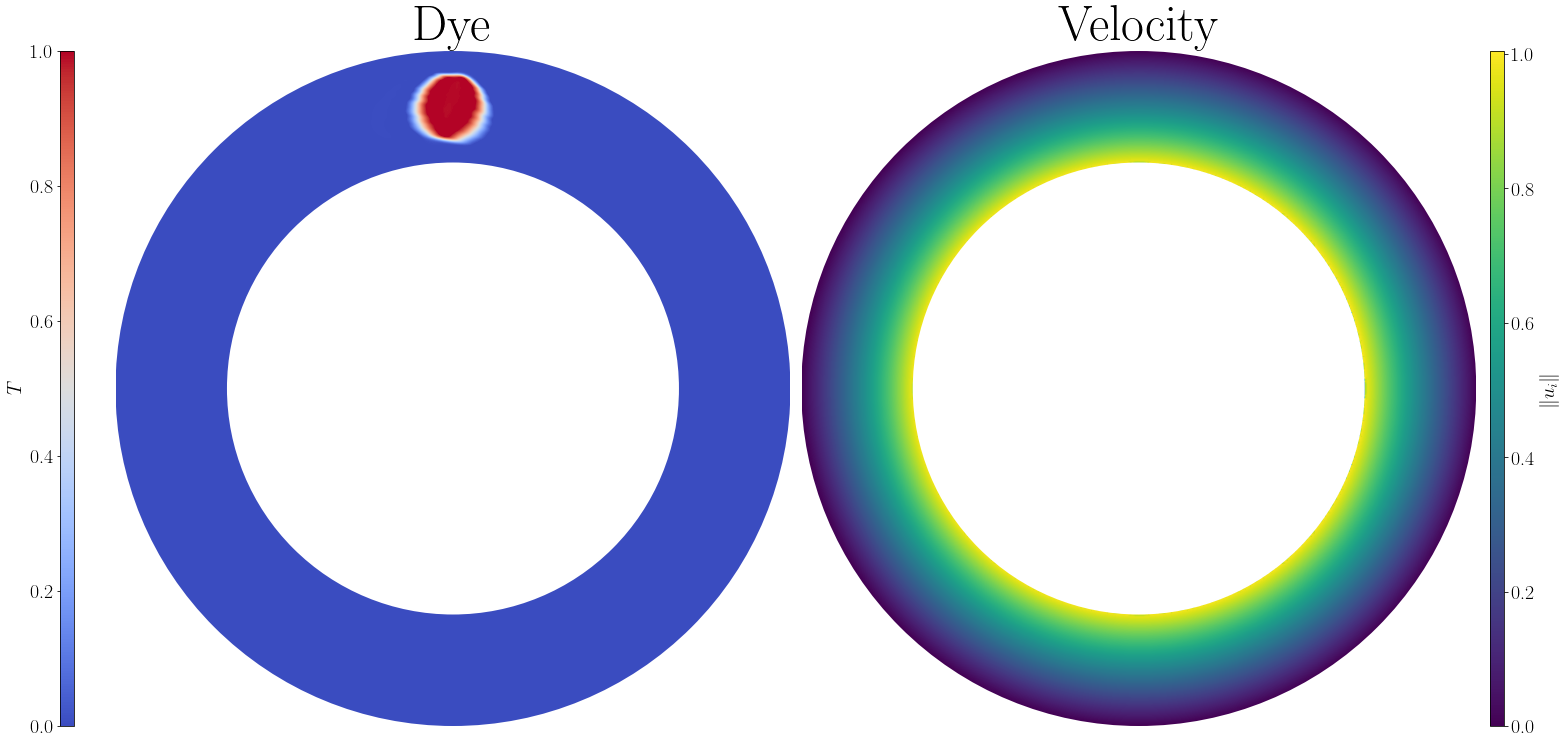

In [15]:
process_timestep(caseToProcess="../testCases/2-2D_rot_cylinder_ink/restart",
                             folder="img",
                             GridsPerR=512, rmin=-1.5, rmax=1.5, 
                             zmin=-1.5, zmax=1.5, lw=2)

## Post processing code for 2-LidDrivenCavity-Newtonian.c

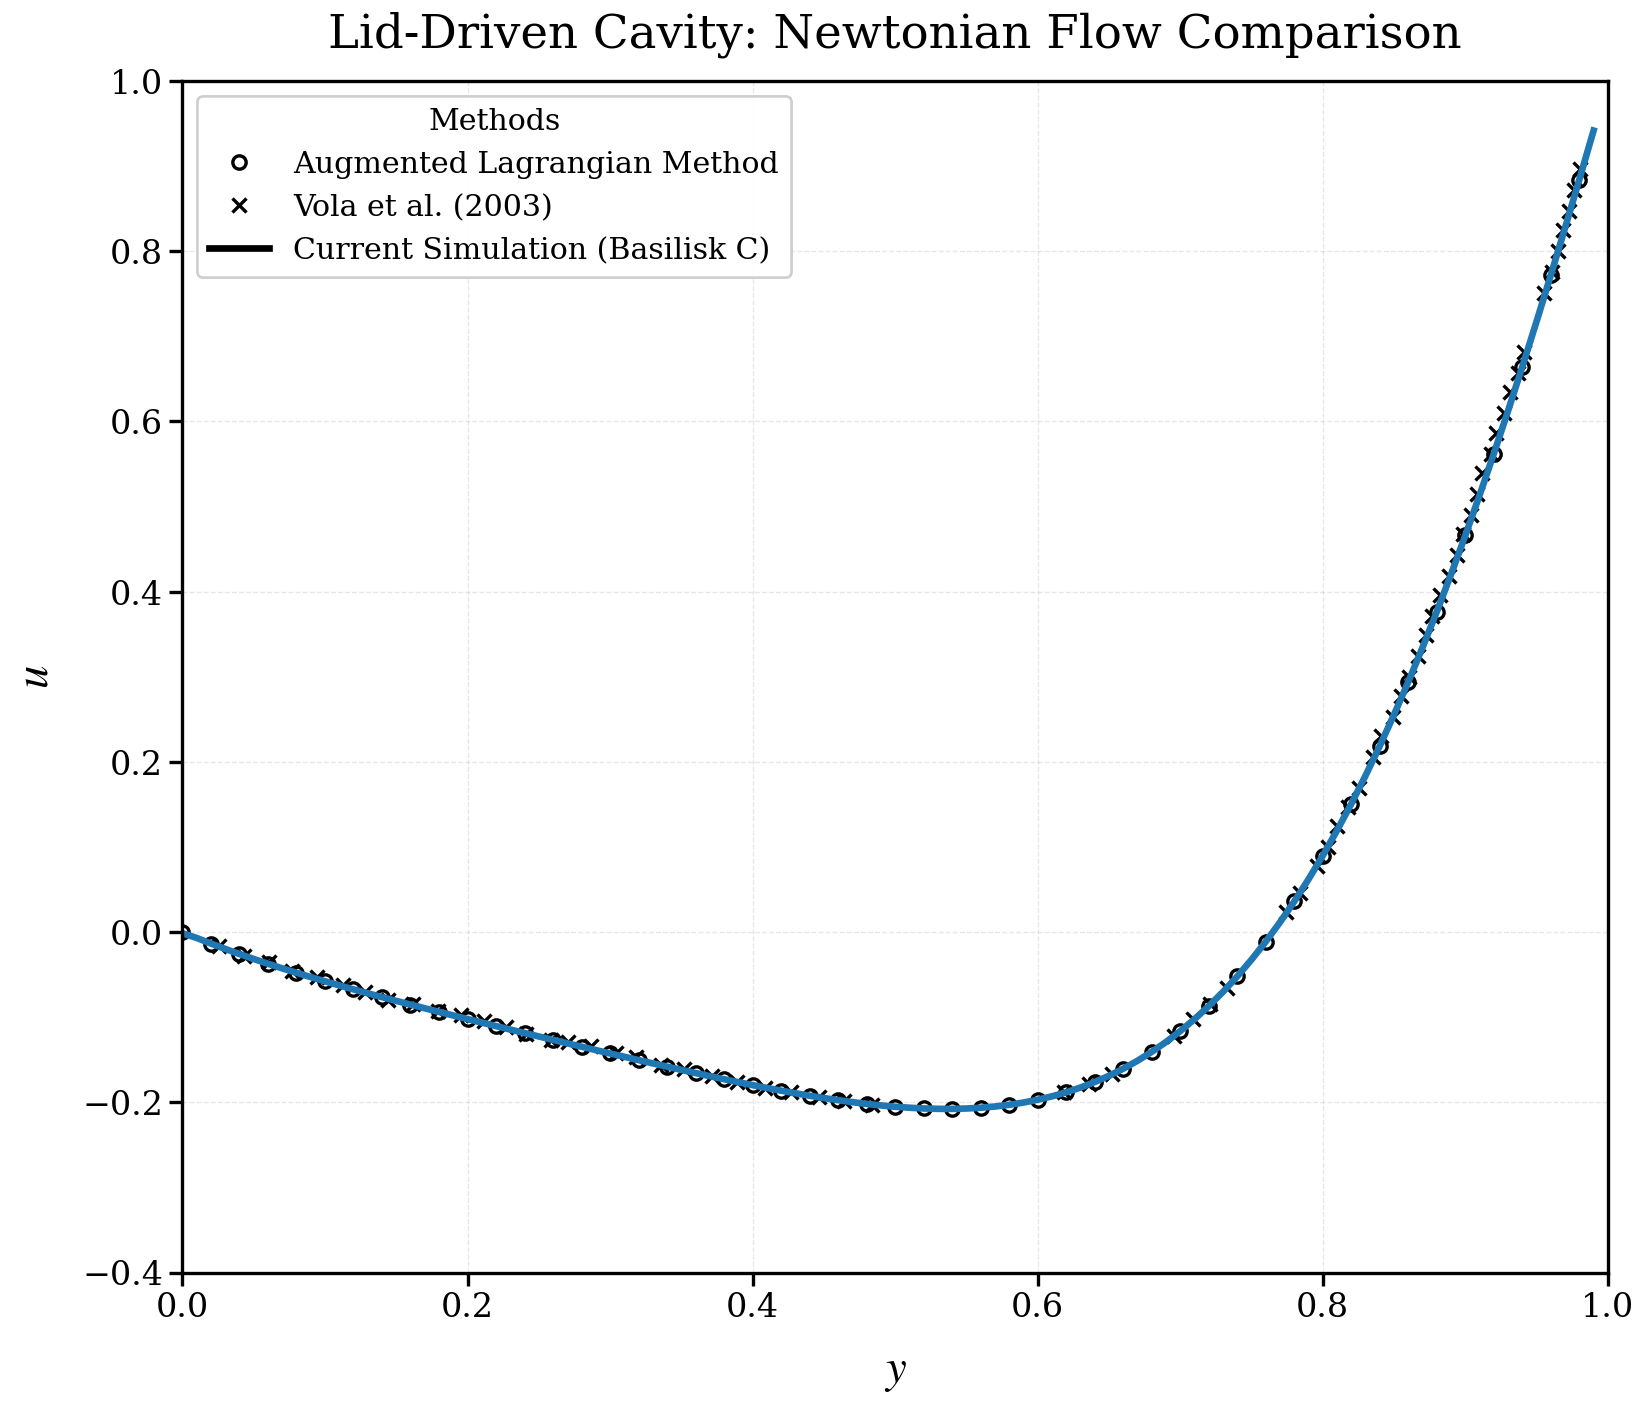

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import matplotlib.colors as mcolors
from scipy.io import loadmat

# Set global font parameters for publication quality
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 16,
    'mathtext.fontset': 'stix',
    'axes.labelsize': 24,
    'axes.titlesize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 18,
})

# Load data from .mat files
# - ALM: Augmented Lagrangian Method results from Popinet
pop_data = loadmat('2-LidDrivenCavity-Bingham-Data/Popinet_AugumentedLagrangian.mat')
ALM = pop_data['ALM'][0]

# - Vola: Benchmark results from Vola et al. (2003)
vola_data = loadmat('2-LidDrivenCavity-Bingham-Data/VolaEtAl.mat')
Vola = vola_data['Vola'][0]

# Define paths for Basilisk simulation data files
# - Each file corresponds to a different yield stress value
filename = "../testCases/2-LidDrivenCavity-Newtonian/results"

# Collect Basilisk data by running an external data extraction tool
# - The tool extracts velocity profiles along the vertical centerline
Bas = []
result = subprocess.run(['./getData-Line', filename],
                        capture_output=True, text=True)
y_values, u_values = [], []
# Parse the output line by line
for line in result.stderr.strip().split('\n'):
    parts = line.strip().split()
    if len(parts) >= 2:
        y, u = float(parts[0]), float(parts[1])
        # Adjust y-coordinate (shift by 0.5 to match reference data)
        y_values.append(y + 0.5)
        u_values.append(u)
# Store the extracted data in our collection
Bas.append({'y': np.array(y_values), 'u': np.array(u_values)})

# Create a high-quality figure for publication
fig, ax = plt.subplots(figsize=(14, 12), dpi=120)

# Define a custom color palette with highly distinct colors
# - These colors are chosen to be distinguishable for colorblind viewers
distinct_colors = [
    '#1f77b4',  # blue
]

# Configure plot aesthetics for better readability
ax.grid(True, linestyle='--', alpha=0.3, which='major')
ax.set_axisbelow(True)  # Place grid behind data

# Plot each dataset with improved visibility
nskip = 2  # Skip every other point for ALM data to reduce clutter
basilisk_lines = []

i = 0
# Use a distinct color for each yield stress value
color = distinct_colors[i]

# Plot ALM data (black hollow circles)
ax.plot(ALM[i]['y'][0][0][::nskip],
        ALM[i]['u'][0][0][::nskip],
        'o', color='black', markersize=8, mfc='none', mew=2,
        label='Augmented Lagrangian Method' if i == 0 else None)

# Plot Vola data (black x markers)
ax.plot(Vola[i]['y'][0][0],
        Vola[i]['u'][0][0],
        'x', color='black', markersize=8, mew=2,
        label='Vola et al. (2003)' if i == 0 else None)

# Plot Basilisk data (colored lines with increased width)
line, = ax.plot(Bas[i]['y'],
                Bas[i]['u'],
                '-', linewidth=4, color=color,
                label=None)  # We'll add a single Basilisk entry to the legend later

basilisk_lines.append(line)

# Create custom legend entries for the different methods
# - This approach allows for better control of legend appearance
lines = [plt.Line2D([0], [0], color='black', lw=0, marker='o', markersize=8, mfc='none', mew=2),
         plt.Line2D([0], [0], color='black', lw=0, marker='x', markersize=8, mew=2),
         plt.Line2D([0], [0], color='black', lw=4)]
labels = ['Augmented Lagrangian Method', 'Vola et al. (2003)', 'Current Simulation (Basilisk C)']


# Create two separate legends for methods and yield stress values
# - First legend: different simulation methods
method_legend = ax.legend(lines, labels, loc='upper left', fontsize=18, 
                         framealpha=0.9, fancybox=True, title="Methods")
method_legend.get_frame().set_linewidth(1.5)
method_legend.get_title().set_fontsize(18)

# Add the method legend to the axes
ax.add_artist(method_legend)

# Set axis labels and title with improved formatting
ax.set_xlabel(r'$y$', fontsize=28, labelpad=15)
ax.set_ylabel(r'$u$', fontsize=28, labelpad=15)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([-0.4, 1.0])
ax.set_title('Lid-Driven Cavity: Newtonian Flow Comparison', fontsize=28, pad=20)

# Make tick marks thicker and longer for better visibility
ax.tick_params(width=2, length=8, which='major')
ax.tick_params(width=1.5, length=5, which='minor')

# Make axis spines thicker for better visibility
for spine in ax.spines.values():
    spine.set_linewidth(2)

# Ensure proper layout and save the figure
plt.tight_layout()
fig.set_facecolor('white')
plt.savefig('img/2-LidDrivenCavity-Newtonian.png', bbox_inches='tight')
plt.show()